# FSRS online vs SuperMemo 18

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs-vs-sm18/blob/main/compare.ipynb)

In [1]:
username = 'LMSherlock'
date = '2023-08-10' # YYYY-MM-DD

## 1. SuperMemo Data Filter

This section filters out the repetition history of Concept and Topic. It only keeps the repetition history of Item. It also remove the title of each item for privacy.

You can upload the `Repetition History.txt` file exported from SuperMemo to the following cell. The output will be saved to the same folder as the input file. You can share the output file with others without worrying about privacy. The output file is named `Repetition History-{username}-{date}.txt`.

In [2]:
def correctly_process_file(file_path, output_file_path):
    result_lines = []  # To store the processed lines
    is_item_section = False  # Flag to identify whether we are in an item section

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            # Check if the line starts a new item section
            if line.startswith('Item #'):
                is_item_section = True
                item_number = line.split(":")[0]  # Keep only the "Item #" part
                result_lines.append(item_number)
            elif line.startswith('Topic #') or line.startswith('Concept #'):
                is_item_section = False
            # If in item section, only keep the repetition records
            elif is_item_section and line.startswith('ElNo'):
                result_lines.append(line)
            elif line.startswith('Repetition') or line.startswith('Date'):
                result_lines.append(line)
            elif is_item_section and line == "":
                result_lines.append(line)

    # Saving the processed content to the output file
    with open(output_file_path, 'w', encoding='utf-8') as file:
        for line in result_lines:
            file.write(line + '\n')


input_file_path = './Repetition History.txt'
output_file_path = f'./Repetition History-{username}-{date}.txt'
correctly_process_file(input_file_path, output_file_path)

## 2. SuperMemo Data Converter

This section converts the SM-18 repetition history to the same format as FSRS.

In [3]:
import pandas as pd
import csv

# Function to extract keys and values from a line
def extract_keys_values(line):
    parts = line.strip().split(" ")
    keys, values = [], []
    for part in parts:
        key, value = part.split("=")
        keys.append(key)
        values.append(value)
    return keys, values

filename = f'Repetition History-{username}-{date}'

# Path to the input TXT file
txt_file_path = f'{filename}.txt'

# Extract all unique keys from the data to form the headers
unique_keys = set()
with open(txt_file_path, 'r', encoding='utf-8') as txt_file:
    for line in txt_file:
        if line.startswith("ElNo"):
            keys, _ = extract_keys_values(line)
            unique_keys.update(keys)

# Sort the keys to maintain a consistent order
headers = sorted(list(unique_keys))

# Path to the output CSV file
csv_file_path = f'{filename}.csv'

# Write the data to CSV with the identified headers and considering missing values
with open(txt_file_path, 'r', encoding='utf-8') as txt_file, open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)  # Write the headers

    for line in txt_file:
        if line.startswith("ElNo"):
            keys, values = extract_keys_values(line)

            # Consider missing values by aligning with headers
            row = [None] * len(headers)
            for key, value in zip(keys, values):
                index = headers.index(key)
                row[index] = value

            writer.writerow(row)

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Convert the "Date" column to standard date format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True).dt.strftime('%Y-%m-%d')

# Sort the DataFrame by "ElNo" and "Date" (ascending for both)
df = df.sort_values(by=['ElNo', 'Date'], ascending=[True, True])

print(f"Number of repetitions: {df.shape[0]}")
print(f"Number of items: {df['ElNo'].unique().shape[0]}")

# Remove unnecessary columns
df.drop(["Difficulty", "Hour", "Postpones", "Priority"], axis=1, inplace=True, errors="ignore")

# Remove items that first row was not the first repetition
df = df.groupby('ElNo').filter(lambda group: (group['Rep'].iloc[0] == 1) and (group['Laps'].iloc[0] == 0))
print(f"Number of repetitions: {df.shape[0]}")

# Remove the first repetition of each item
df.drop(df[(df['Rep'] == 1) & (df['Laps'] == 0)].index, inplace=True)
print(f"Number of repetitions: {df.shape[0]}")

# Remove items that have been reset
df = df.groupby('ElNo').filter(lambda group: (group['Grade'] > 5).sum() == 0)
print(f"Number of repetitions: {df.shape[0]}")

# Remove items that have invalid "expFI" values
df = df.groupby('ElNo').filter(lambda group: (group['expFI'] == 100).sum() == 0)
print(f"Number of repetitions: {df.shape[0]}")

# Keep the first repetitions of the same item on the same day
df.drop_duplicates(subset=['Date', 'ElNo'], keep='first', inplace=True)
print(f"Number of repetitions: {df.shape[0]}")

# Rank the repetitions of each item
df['i'] = df.groupby('ElNo').cumcount() + 1

# Calculate the time difference between repetitions
df['Date'] = pd.to_datetime(df['Date'])
df['delta_t'] = df['Date'].diff().dt.days
df['delta_t'] = df['delta_t'].fillna(0)
df.loc[df['i'] == 1, 'delta_t'] = 0
df['delta_t'] = df['delta_t'].astype(int)

# Rename columns to match FSRS dataset format
df.rename(columns={'ElNo': 'card_id', 'Date': 'review_date'}, inplace=True)

# Convert "Grade" to "review_rating"
# 0, 1, 2 -> 1, 3 -> 2, 4 -> 3, 5 -> 4
df['review_rating'] = df['Grade'].map({0: 1, 1: 1, 2: 1, 3: 2, 4: 3, 5: 4})
df['review_time'] = 0


# Create "t_history" and "r_history" features for training FSRS
from itertools import accumulate

def cum_concat(x):
    return list(accumulate(x))

t_history = df.groupby('card_id', group_keys=False)['delta_t'].apply(lambda x: cum_concat([[int(i)] for i in x]))
df['t_history']=[','.join(map(str, item[:-1])) for sublist in t_history for item in sublist]
r_history = df.groupby('card_id', group_keys=False)['review_rating'].apply(lambda x: cum_concat([[i] for i in x]))
df['r_history']=[','.join(map(str, item[:-1])) for sublist in r_history for item in sublist]

# Create "y" label for training FSRS
df['y'] = df['review_rating'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
df.dropna(inplace=True)
print(f"Number of repetitions: {df.shape[0]}")

def remove_non_continuous_rows(group):
    discontinuity = group['i'].diff().fillna(1).ne(1)
    if not discontinuity.any():
        return group
    else:
        first_non_continuous_index = discontinuity.idxmax()
        return group.loc[:first_non_continuous_index-1]

df = df.groupby('card_id', as_index=False, group_keys=False).apply(remove_non_continuous_rows)
print(f"Number of repetitions: {df.shape[0]}")

# Save the final dataset
df.to_csv('revlog_history.tsv', sep="\t", index=False)

Number of repetitions: 47196
Number of items: 10702
Number of repetitions: 47190
Number of repetitions: 36445
Number of repetitions: 35850
Number of repetitions: 35074
Number of repetitions: 35068
Number of repetitions: 35058
Number of repetitions: 35049


## 3. Train & Compare

Here is a fair comparison between FSRS and SM-18. 

In FSRS online, each repetition is only used once. The repetitions are sorted by the review date ascending. Then FSRS will make prediction one by one and update the model after each prediction. So FSRS online has zero knowledge of the future reviews as SM-18 does.

In [4]:
%pip install -q FSRS-Optimizer==4.11.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
from fsrs_optimizer import lineToTensor, collate_fn, power_forgetting_curve, plot_brier, FSRS, RevlogDataset, WeightClipper, Optimizer

tqdm.pandas()

revlogs = pd.read_csv('revlog_history.tsv', sep='\t', keep_default_na=False)
revlogs = revlogs[(revlogs['i'] > 1) & (revlogs['delta_t'] > 0) & (revlogs['t_history'].str.count(',0') == 0)].copy()

revlogs['tensor'] = revlogs.progress_apply(lambda x: lineToTensor(list(zip([x['t_history']], [x['r_history']]))[0]), axis=1)
revlogs.sort_values(by=['review_date'], inplace=True)
revlogs.reset_index(drop=True, inplace=True)

Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/25011 [00:00<?, ?it/s]

In [5]:
model = FSRS([0.4, 0.6, 2.4, 5.8, 4.93, 0.94, 0.86, 0.01, 1.49, 0.14, 0.94, 2.18, 0.05, 0.34, 1.26, 0.29, 2.61])
optimizer = torch.optim.Adam(model.parameters(), lr=8e-3)
loss_fn = torch.nn.BCELoss(reduction='none')

dataset = RevlogDataset(revlogs)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
clipper = WeightClipper()
d = []
s = []
r = []

for batch in tqdm(dataloader):
    model.train()
    optimizer.zero_grad()
    sequences, delta_ts, labels, seq_lens = batch
    outputs, _ = model(sequences)
    stabilities, difficulties = outputs[seq_lens-1, 0].transpose(0, 1)
    d.append(difficulties.detach().numpy()[0])
    s.append(stabilities.detach().numpy()[0])
    retentions = power_forgetting_curve(delta_ts, stabilities)
    r.append(retentions.detach().numpy()[0])
    loss = loss_fn(retentions, labels).sum()
    loss.backward()
    optimizer.step()
    model.apply(clipper)

revlogs['difficulty'] = d
revlogs['stability'] = s
revlogs['p'] = r

for name, param in model.named_parameters():
    print(f"{name}: {list(map(lambda x: round(float(x), 4),param))}")

  0%|          | 0/25011 [00:00<?, ?it/s]

w: [3.3587, 10.6774, 23.1108, 35.1857, 4.1494, 2.3024, 1.3295, 0.0, 1.8483, 0.5414, 1.2499, 2.4226, 0.0521, 0.3591, 1.3132, 0.5716, 2.8]


Loss of FSRS online: 0.3642
R-squared: -1.7232
RMSE: 0.0920
MAE: 0.0545
[0.55213966 0.3931113 ]


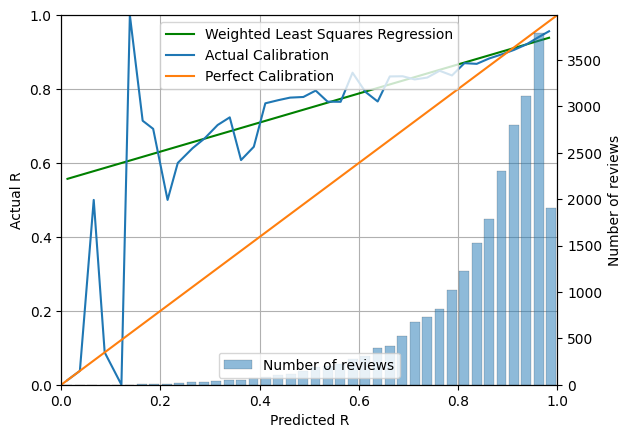

In [6]:
revlogs['log_loss'] = revlogs.apply(lambda row: - np.log(row['p']) if row['y'] == 1 else - np.log(1 - row['p']), axis=1)
log_loss = revlogs['log_loss'].mean()
print(f"Loss of FSRS online: {log_loss:.4f}")

fig0 = plt.figure()
fsrs_metrics = plot_brier(revlogs['p'], revlogs['y'], bins=40, ax=fig0.add_subplot(111))
fsrs_metrics['log_loss'] = log_loss
fig0.show()

Loss of SM-18: 0.3916
R-squared: -3.9841
RMSE: 0.1283
MAE: 0.0617
[0.63377305 0.29572659]
Universal Metric of FSRS: 0.0417
Universal Metric of SM18: 0.0446


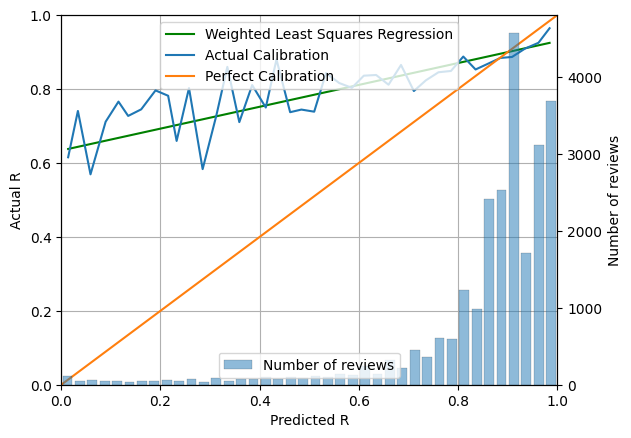

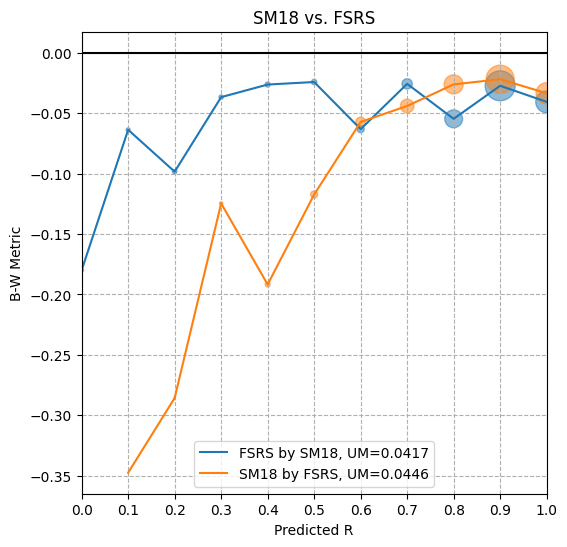

In [7]:
revlogs['sm18_p'] = 1 - revlogs['expFI'] / 100
revlogs['log_loss'] = revlogs.apply(lambda row: - np.log(row['sm18_p']) if row['y'] == 1 else - np.log(1 - row['sm18_p']), axis=1)
log_loss = revlogs['log_loss'].mean()
print(f"Loss of SM-18: {log_loss:.4f}")
cross_comparison = revlogs[['sm18_p', 'p', 'y']].copy()
fig1 = plt.figure()
sm18_metrics = plot_brier(cross_comparison['sm18_p'], cross_comparison['y'], bins=40, ax=fig1.add_subplot(111))
sm18_metrics['log_loss'] = log_loss
fig1.show()

fig2 = plt.figure(figsize=(6, 6))
ax = fig2.gca()

cross_comparison['SM18_B-W'] = cross_comparison['sm18_p'] - cross_comparison['y']
cross_comparison['SM18_Bin'] = cross_comparison['sm18_p'].map(lambda x: round(x, 1))
cross_comparison['FSRS_B-W'] = cross_comparison['p'] - cross_comparison['y']
cross_comparison['FSRS_bin'] = cross_comparison['p'].map(lambda x: round(x, 1))

ax.axhline(y = 0.0, color = 'black', linestyle = '-')

cross_comparison_group = cross_comparison.groupby(by='SM18_Bin').agg({'y': ['mean'], 'FSRS_B-W': ['mean'], 'p': ['mean', 'count']})
universal_metric = mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['p', 'mean'], sample_weight=cross_comparison_group['p', 'count'], squared=False)
fsrs_metrics['universal_metric'] = universal_metric
print(f"Universal Metric of FSRS: {universal_metric:.4f}")
cross_comparison_group['p', 'percent'] = cross_comparison_group['p', 'count'] / cross_comparison_group['p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['FSRS_B-W', 'mean'], s=cross_comparison_group['p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['FSRS_B-W', 'mean'], label=f'FSRS by SM18, UM={universal_metric:.4f}')

cross_comparison_group = cross_comparison.groupby(by='FSRS_bin').agg({'y': ['mean'], 'SM18_B-W': ['mean'], 'sm18_p': ['mean', 'count']})
universal_metric = mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['sm18_p', 'mean'], sample_weight=cross_comparison_group['sm18_p', 'count'], squared=False)
sm18_metrics['universal_metric'] = universal_metric
print(f"Universal Metric of SM18: {universal_metric:.4f}")
cross_comparison_group['sm18_p', 'percent'] = cross_comparison_group['sm18_p', 'count'] / cross_comparison_group['sm18_p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['SM18_B-W', 'mean'], s=cross_comparison_group['sm18_p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['SM18_B-W', 'mean'], label=f'SM18 by FSRS, UM={universal_metric:.4f}')

ax.legend(loc='lower center')
ax.grid(linestyle='--')
ax.set_title("SM18 vs. FSRS")
ax.set_xlabel('Predicted R')
ax.set_ylabel('B-W Metric')
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))

fig2.show()

In [8]:
{
    'user': username,
    'date': date,
    'size': len(revlogs),
    'fsrs': fsrs_metrics,
    'sm18': sm18_metrics
}

{'user': 'LMSherlock',
 'date': '2023-08-10',
 'size': 25011,
 'fsrs': {'R-squared': -1.7232462991240478,
  'RMSE': 0.09198407540458281,
  'MAE': 0.05445375689957937,
  'log_loss': 0.3642238521584406,
  'universal_metric': 0.04172272132164846},
 'sm18': {'R-squared': -3.9840506224985965,
  'RMSE': 0.12826199255131357,
  'MAE': 0.0617496301627363,
  'log_loss': 0.39155606425312545,
  'universal_metric': 0.04458352050264969}}